# Quick start

This notebook shows how to use `osculari` to conduct psychophysics on deep neural networks. We learn:
* Extract features from an intermediate layer of the `ResNet` network.
* To train a two-alternative-forced-choice (2AFC) linear probe on the frozen pretrained network.
* Evaluate the network's sensitivity using the staircase procedure.

In [29]:
import osculari

import numpy as np
from matplotlib import pyplot as plt
import torch

## Prtrained features



In [18]:
architecture = 'resnet50'
weights = 'resnet50'
img_size = 224
readout_kwargs = {
    'architecture': architecture, 
    'weights': weights,
    'layers': 'block0',
    'img_size': img_size,
}
classifier_kwargs  = {
    'pooling': None
}
net_2afc = osculari.models.cat_paradigm_2afc(**readout_kwargs, **classifier_kwargs)

## Dataset

In [19]:
def contrast_fun(fgs, bgs):
    num_imgs = len(fgs)
    contrast0, contrast1 = np.random.uniform(0.04, 1, 2)
    gt = 0 if contrast0 > contrast1 else 1
    contrasts = [contrast0, contrast1]
    colour = [np.random.randint(0, 256) for _ in range(3)]
    imgs = []
    for i in range(num_imgs):
        img = bgs[i].copy()
        for c in range(3):
            chn = img[..., c]
            chn[fgs[i]] = colour[c] / 255
            img[..., c] = chn
        img = ((1 - contrasts[i]) / 2.0 + np.multiply(img, contrasts[i]))
        imgs.append(img)
    return imgs, gt

In [20]:
num_samples = 1000
num_imgs = 2
background = 128
db = osculari.datasets.geometrical_shapes.ShapeAppearanceDataset(
    num_samples, num_imgs, img_size, background, contrast_fun,
    unique_bg=True, transform=net_2afc.preprocess_transform()
)

## Linear Probe

In [21]:
training_log = osculari.paradigms.paradigm_utils.train_linear_probe(
    net_2afc, db, osculari.paradigms.forced_choice.epoch_loop, '/home/arash/Desktop/osculari_test/'
)

[000] accuracy=0.535 loss=461355.910
[001] accuracy=0.665 loss=212465.201
[002] accuracy=0.737 loss=124832.898
[003] accuracy=0.766 loss=97018.309
[004] accuracy=0.739 loss=123537.093
[005] accuracy=0.837 loss=48730.988
[006] accuracy=0.872 loss=35222.131
[007] accuracy=0.853 loss=42248.412
[008] accuracy=0.874 loss=38596.327
[009] accuracy=0.894 loss=19067.322


## Psychophysical experiment

In [23]:
class ContrastGratingsDataset(osculari.datasets.gratings.GratingsDataset):

    def __init__(self, img_size, contrasts, sf, **kwargs):
        super(ContrastGratingsDataset, self).__init__(img_size, spatial_frequencies=[sf], **kwargs)
        self.contrasts = contrasts


    def __getitem__(self, idx):
        stimuli0 = self.make_grating(idx, self.contrasts[0])
        stimuli1 = self.make_grating(idx, self.contrasts[1])
        if self.transform:
            stimuli0 = self.transform(stimuli0).float()
            stimuli1 = self.transform(stimuli1).float()
        gt = np.argmax(self.contrasts)
        return stimuli0, stimuli1, gt

In [24]:
test_db = ContrastGratingsDataset(224, [0., 1], 4, gaussian_sigma=None)

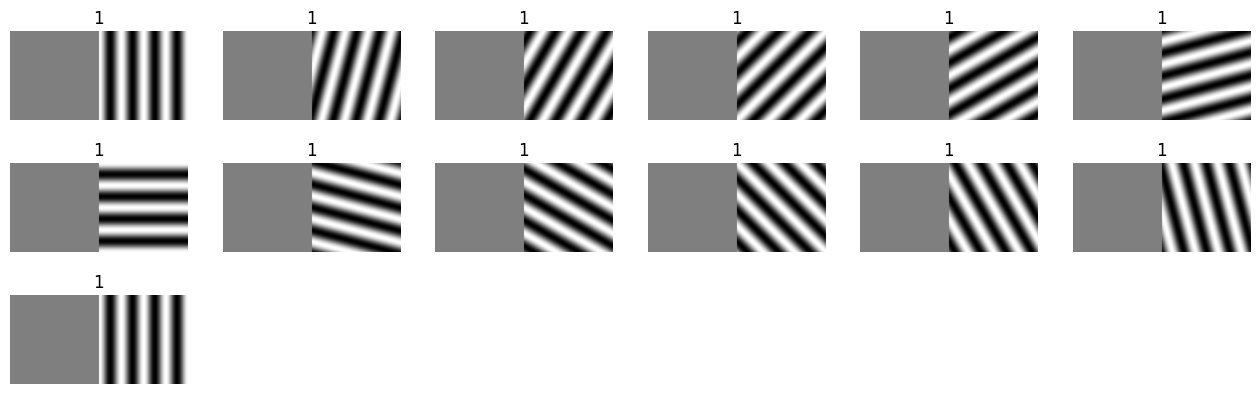

In [27]:
fig = plt.figure(figsize=(16, 10))
for i in range(test_db.__len__()):
    ax = fig.add_subplot(6, 6, i+1)
    inputs = test_db.__getitem__(i)
    ax.imshow(np.concatenate([inputs[0], inputs[1]], axis=1))
    ax.set_title(inputs[2])
    ax.axis('off')

In [30]:
def dataset_fun(contrast_level, sf, transform):
    test_db = torch.utils.data.ConcatDataset([
        ContrastGratingsDataset(224, [contrast_level, 0], sf, gaussian_sigma=None, transform=transform),
        ContrastGratingsDataset(224, [0, contrast_level], sf, gaussian_sigma=None, transform=transform)
    ])
    return test_db, test_db.__len__(), 0.749

In [32]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sfs = [i for i in range(1, img_size // 2 + 1) if img_size % i == 0]
csf = []
for sf in sfs:
    db_fun = lambda contrast: dataset_fun(contrast, sf, net_2afc.preprocess_transform())
    res = osculari.paradigms.staircase(net_2afc, osculari.paradigms.forced_choice.test_dataset, db_fun, device, 0, 1)
    csf.append(res[-1, 0])

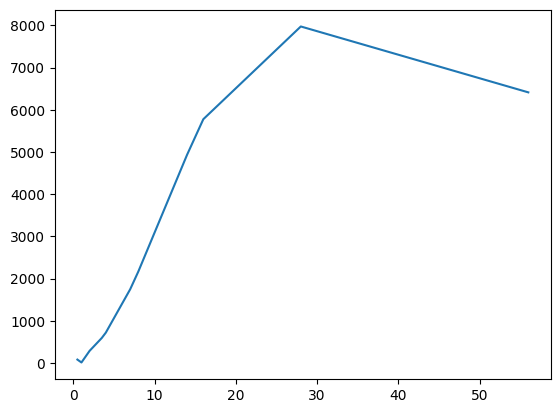

In [33]:
plt.plot(np.array(sfs)/2, 1/np.array(csf))